In [1]:

import pandas as pd
import numpy as np
import pyaf.ForecastEngine as autof
import pyaf.Bench.TS_datasets as tsds
#import SignalDecomposition_Perf as tsperf

In [18]:

def add_some_noise(x , p , min_sig, max_sig, e , f):
    delta = (x - min_sig) / (max_sig - min_sig);
    if( (delta >= e) and (delta <= f) ):
        if(np.random.random() < p):
            return 1;
    return 0;


def gen_trend(N , trendtype):
    lTrend = pd.Series();
    a = 100* (2 * np.random.random() - 1);
    b = 10 * (2 * np.random.random() - 1);
    c = (2 * np.random.random() );
    print("TREND" , a , b ,c);
    if(trendtype == "constant"):
        lTrend = a
    if(trendtype == "linear"):
        x = np.arange(0,N) / (N );
        lTrend =  a * x + b;
    if(trendtype == "poly"):
        x = np.arange(0,N) / (N );
        lTrend =  a * x * x + b * x + c;
    # lTrend.plot();
    return lTrend;

def gen_cycle(N , cycle_length):
    lCycle = pd.Series();
    if(cycle_length > 0):
        lCycle = np.arange(0,N) % cycle_length;
        lValues = np.random.randint(0, cycle_length, size=(cycle_length, 1)) /cycle_length;
        lCycle = pd.Series(lCycle).apply(lambda x : lValues[int(x)][0]);
    if(cycle_length == 0):
        lCycle = 0;
    return lCycle;
    

def generate_random_TS_2(N , FREQ, seed, trendtype, cycle_length, transform, sigma = 1.0, exog_count = 20) :
    tsspec = tsds.cTimeSeriesDatasetSpec();
    tsspec.mName = "Signal_" + str(N) + "_" + str(FREQ) +  "_" + str(seed)  + "_" + str(trendtype) +  "_" + str(cycle_length)   + "_" + str(transform)   + "_" + str(sigma) + "_" + str(exog_count) ;
    print("GENERATING_RANDOM_DATASET" , tsspec.mName);
    tsspec.mDescription = "Random generated dataset";

    np.random.seed(seed);

    df_train = pd.DataFrame();
    #df_train['Date'] = np.arange(0,N)

    '''
    http://pandas.pydata.org/pandas-docs/stable/timeseries.html
    DateOffset objects

    In the preceding examples, we created DatetimeIndex objects at various frequencies by passing in frequency strings
    like "M", "W", and "BM" to the freq keyword. Under the hood, these frequency strings are being translated into an
    instance of pandas DateOffset, which represents a regular frequency increment.
    Specific offset logic like "month", "business day", or "one hour" is represented in its various subclasses.
    '''
    df_train['Date'] = pd.date_range('2000-1-1', periods=N, freq=FREQ)
    df_train['GeneratedTrend'] = gen_trend(N , trendtype);

    df_train['GeneratedCycle'] = gen_cycle(N , cycle_length);

    df_train['Noise'] = np.random.randn(N) * sigma;
    df_train['Signal'] = df_train['GeneratedTrend'] +  df_train['GeneratedCycle'] + df_train['Noise']

    min_sig = df_train['Signal'].min();
    max_sig = df_train['Signal'].max();
    print(df_train.info())
    tsspec.mExogenousVariables = [];
    for e in range(exog_count):
        label = "exog_" + str(e+1);
        df_train[label] = df_train['Signal'].apply(lambda x : add_some_noise(x , 0.1 , 
                                                                             min_sig, 
                                                                             max_sig, 
                                                                             e/exog_count ,
                                                                             (e+3)/exog_count ));
        tsspec.mExogenousVariables = tsspec.mExogenousVariables + [ label ];

    # this is the full dataset . must contain future exogenius data
    tsspec.mExogenousDataFrame = df_train;
    pos_signal = df_train['Signal'] - min_sig + 1.0;

    if(transform == "exp"):
        df_train['Signal'] = np.exp(-pos_signal)

    # df_train.to_csv(tsspec.mName + ".csv");

    tsspec.mTimeVar = "Date";
    tsspec.mSignalVar = "Signal";
    tsspec.mHorizon = 12;
    if(tsspec.mHorizon > (N//2)):
        tsspec.mHorizon = N // 2;
    tsspec.mFullDataset = df_train;
    tsspec.mFullDataset[tsspec.mName] = tsspec.mFullDataset['Signal'];
    tsspec.mPastData = df_train[:-tsspec.mHorizon];
    tsspec.mFutureData = df_train.tail(tsspec.mHorizon);
    
    return tsspec



In [19]:
%matplotlib inline

def plot_dataset(idataset):
    df = idataset.mPastData
    df.plot(idataset.mTimeVar, [idataset.mSignalVar , 'GeneratedTrend' , 'GeneratedCycle'] , figsize=(32, 16))

def process_dataset(idataset):

        df = idataset.mPastData

        # df.to_csv("outputs/rand_exogenous.csv")
    
        H = idataset.mHorizon;
    
        N = df.shape[0];
        df1 = df;
        lEngine = autof.cForecastEngine()
        lExogenousData = (idataset.mExogenousDataFrame , idataset.mExogenousVariables) 
        lEngine.train(df1 , idataset.mTimeVar , idataset.mSignalVar, H, lExogenousData);
        lEngine.getModelInfo();
        # lEngine.standrdPlots(name = "outputs/my_exog_" + str(nbex) + "_" + str(n));


GENERATING_RANDOM_DATASET Signal_128_D_20_poly_20__0.9_5
TREND 17.626160215454846 7.954274558188359 1.783061458949416
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 5 columns):
Date              128 non-null datetime64[ns]
GeneratedTrend    128 non-null float64
GeneratedCycle    128 non-null float64
Noise             128 non-null float64
Signal            128 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.1 KB
None


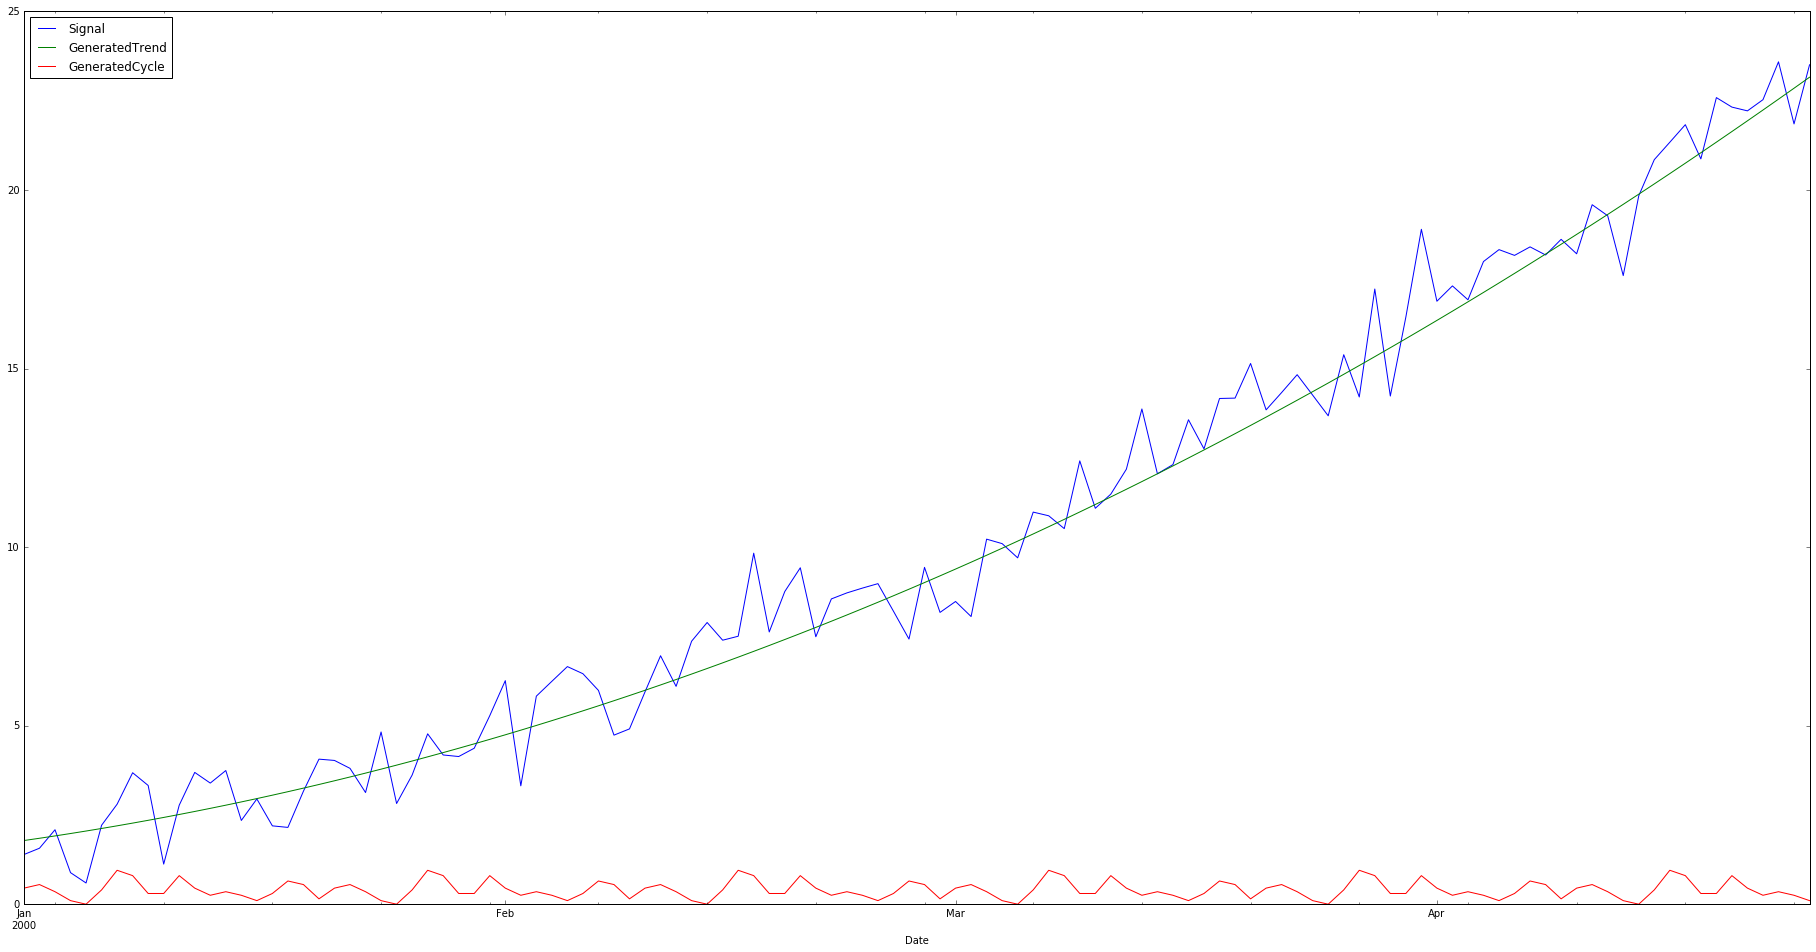

In [21]:
dataset = generate_random_TS_2(N = 128 , FREQ = 'D', seed = 20, trendtype = "poly", cycle_length = 20, transform = "", sigma = 0.9, exog_count = 5);
plot_dataset(dataset)
